In [213]:
# ENVIRONMENT SETUP 

# Importing required packages
import geopandas as gpd
import shapely
from pyomo.environ import *

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [214]:
# LOAD & INSPECT THE DATA

# Set the filepath
fp = "/Users/viviandiberardino/Documents/Research assistant assessment/take_home/land_parcels.shp"

# Read file into land_data
land_data = gpd.read_file(fp)

# Print first five rows for inspection
land_data.head()


,parcel_id,carbon_sto,cost,geometry
0,0,57.050444,4706.178160,"POLYGON ((-95.02850 49.00837, -95.02067 49.090..."
1,1,28.383328,3722.863104,"POLYGON ((-94.91661 48.98650, -94.90980 49.127..."
2,2,31.481736,2281.036311,"POLYGON ((-94.78940 49.01419, -94.82420 49.075..."
3,3,70.452120,1849.986859,"POLYGON ((-94.72478 49.02353, -94.69378 49.120..."
4,4,38.455948,3883.390216,"POLYGON ((-94.62821 48.99532, -94.58622 49.118..."


<Axes: >

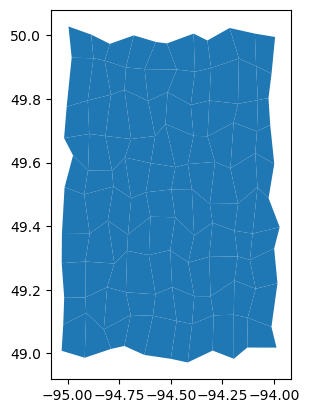

In [215]:
# Plot the land parcels
land_data.plot()

In [216]:
# Get polygon count
land_data.count()

parcel_id     100
carbon_sto    100
cost          100
geometry      100
dtype: int64

There are 100 polygons in this shapefile.

In [217]:
# Range of carbon store attribute
max_carbon = land_data["carbon_sto"].max()
min_carbon = land_data["carbon_sto"].min()

In [218]:
# Max carbon
max_carbon

99.8608996768998

In [219]:
# Min carbon
min_carbon

10.036534572755878

Therefore, the carbon store attributes of the polygons range from about 10.03 to about 99.86

In [220]:
# Range of cost attribute
max_cost = land_data["cost"].max()
min_cost = land_data["cost"].min()

In [221]:
# Max cost
max_cost

4982.434015347925

In [222]:
# Min cost
min_cost

524.9516816211429

Therefore, the cost attributes of the polygons range from \\$524.95 to \\$4982.43.

In [223]:
# REPROJECT

# Show current coordinate information
land_data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [224]:
# Create a new GeoDataFrame that reprojects polygons to EPSG: 3347
land_data_reproj = land_data.to_crs(epsg = 3347)

In [225]:
# Show reproected data frame information
land_data_reproj.crs

<Projected CRS: EPSG:3347>
Name: NAD83 / Statistics Canada Lambert
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Canada - onshore and offshore - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon.
- bounds: (-141.01, 40.04, -47.74, 86.46)
Coordinate Operation:
- name: Statistics Canada Lambert
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

We can see that the geometry info is in metres, so when we calculate area, it will give an answer in $m^2$.

We will need to convert to $km^2$ ($1 km^2$ = $1,000,000 m^2$).

In [226]:
# Calculate and store the areas of the reprojected polygons
# Add a new column to our GeoDataFrame
land_data_reproj["area (km^2)"] = land_data_reproj.area / 1000000

# Inspect the first few rows of the new data frame
land_data_reproj.head()

,parcel_id,carbon_sto,cost,geometry,area (km^2)
0,0,57.050444,4706.178160,"POLYGON ((5968785.255 1435665.700, 5969809.576...",100.449718
1,1,28.383328,3722.863104,"POLYGON ((5976844.621 1432837.351, 5978091.625...",86.099510
2,2,31.481736,2281.036311,"POLYGON ((5986286.960 1435475.950, 5984061.538...",63.283784
3,3,70.452120,1849.986859,"POLYGON ((5991055.082 1436299.049, 5993801.256...",95.907490
4,4,38.455948,3883.390216,"POLYGON ((5997974.226 1432852.392, 6001629.866...",123.672542


In [227]:
# Minimum area of polygons (km^2) after reprojecting
min_area = land_data_reproj["area (km^2)"].min()
min_area

37.37824723690508

Therefore the minimum area of the polygons is about $37.38 km^2$.

In [228]:
 # Average area of polygons (km^2) after reprojecting 
mean_area = land_data_reproj["area (km^2)"].mean()
mean_area

80.54030444813331

Therefore the mean area of the polygons is about $80.54 km^2$.

In [229]:
# Maximum area of polygons (km^2) after reprojecting 
max_area = land_data_reproj["area (km^2)"].max()
max_area

132.09554286309267

Therefore the max area of the polygons is about $132.096 km^2$.

<Axes: >

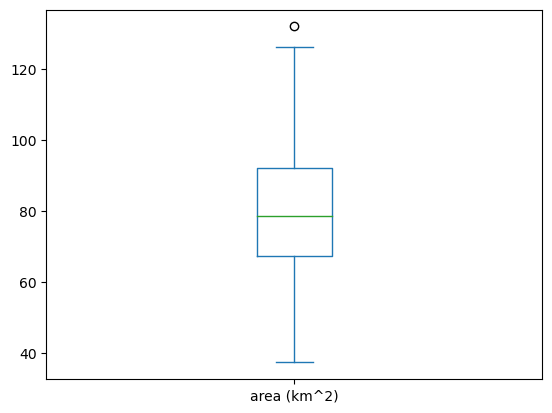

In [230]:
# FILTER

# Determining a reasonable area threshold
# We can plot a boxplot of the land data, and inspect it to determine outliers
land_data_reproj["area (km^2)"].plot(kind = "box")


Just from the boxplot, it looks like there is one outlier. 
This is the polygon with the maximum area, so we may want to consider removing it.


In [231]:
# Filter out max area polygon from our data frame
land_data_reproj = land_data_reproj.drop(land_data_reproj[land_data_reproj["area (km^2)"] == max_area].index)

<Axes: >

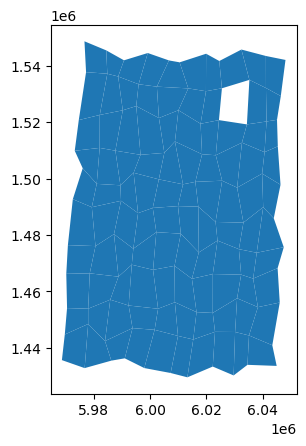

In [232]:
# Replotting the new polygons
land_data_reproj.plot()

In [233]:
# COMPUTE ADJACENCY

# Initializes adjacency matrix
adj_matrix = [[0]*99 for i in range(99)]

# Rows and columns correspond to the parcel_id
# 99 polygons to check so 99x99 matrix
# if parcel_id i and parcel_id j are sharing an edge, adj_matrix[i][j] and adj_matrix[j][i] will have a value of 1 and 0 otherwise
for parcel_id1 in range(99):
    for parcel_id2 in range(99):
        if type((land_data_reproj.iloc[parcel_id1]["geometry"]).intersection(land_data_reproj.iloc[parcel_id2]["geometry"])) \
        is shapely.LineString:
            adj_matrix[parcel_id1][parcel_id2] = 1
        else:
            adj_matrix[parcel_id1][parcel_id2] = 0

# Print the adjacency matrix
for row in adj_matrix:
    print(row)

        


[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [234]:
# OPTIMIZATION TASK

# Calculate cost all polygons * 0.5
cost_50_all = (land_data_reproj["cost"].sum())*0.5

# Set up optimization problem
carbon_prob = ConcreteModel()

# Sets
carbon_prob.P = RangeSet(0, len(land_data_reproj) - 1)

# Decision Variables (x[i] = 1 if polygon i is selected)
carbon_prob.x = Var(carbon_prob.P, within=Binary)

# Define the objective function: maximize the carbon store
carbon_prob.obj = Objective(expr=sum(land_data_reproj.iloc[i]["carbon_sto"] * carbon_prob.x[i] for i in carbon_prob.P), sense=maximize)

# Define constraint 1: cost must not exceed 50% of the sum of cost of all polygons
carbon_prob.cost_constraint = Constraint(expr=sum(land_data_reproj.iloc[i]["cost"] * carbon_prob.x[i] for i in carbon_prob.P) <= cost_50_all)

# Define constraint 2: no two polygons can share an edge
carbon_prob.adj_constraints = ConstraintList()

for i in range(len(land_data_reproj)):
    for j in range (i + 1, len(land_data_reproj)): # only need to check one park of adjacency matrix (other half is redudant)
        if adj_matrix[i][j] == 1: # if parcel_id i and parcel_id j are adjacent
            carbon_prob.adj_constraints.add(carbon_prob.x[i] + carbon_prob.x[j] <= 1) # Make sure that BOTH polygons are not chosen 


# Solve the optimization problem
solver = SolverFactory('glpk') # use glpk solver
result = solver.solve(carbon_prob)


# Show the results
print("Status:", result.solver.status)
print("Objective Value (Max Carbon Store):", carbon_prob.obj()) # print maximum carbon store

# Print the selected polygons
selected = [i for i in carbon_prob.P if carbon_prob.x[i]() == 1] # if polygon selected, place into selected
selected_list = land_data_reproj.iloc[selected]['parcel_id'].tolist() # turn selected into a list
print("Selected parcel IDs:", selected_list) # print list of selected polygons




Status: ok
Objective Value (Max Carbon Store): 2829.362899033295
Selected parcel IDs: [0, 2, 4, 6, 8, 11, 13, 15, 17, 19, 20, 22, 26, 28, 31, 33, 35, 37, 39, 40, 42, 44, 46, 48, 51, 53, 55, 57, 59, 60, 62, 64, 66, 68, 71, 73, 75, 77, 79, 80, 82, 84, 88, 91, 93, 96, 99]


In [235]:
# Create new data frame with the selected polygons
selected_polys_frame = land_data

# Need to use land_data, because land_data_reproj has a land parcel removed, which changes the indexes
for poly in range(99):
    if int(land_data.iloc[poly]["parcel_id"]) not in selected_list: # if polygon not chosen, remove it from the data frame
        selected_polys_frame = selected_polys_frame.drop(selected_polys_frame[selected_polys_frame["parcel_id"] == poly].index)

# Output the new frame on screen
selected_polys_frame



,parcel_id,carbon_sto,cost,geometry
0,0,57.050444,4706.178160,"POLYGON ((-95.02850 49.00837, -95.02067 49.090..."
2,2,31.481736,2281.036311,"POLYGON ((-94.78940 49.01419, -94.82420 49.075..."
4,4,38.455948,3883.390216,"POLYGON ((-94.62821 48.99532, -94.58622 49.118..."
6,6,99.860900,4982.434015,"POLYGON ((-94.41807 48.97159, -94.39688 49.092..."
8,8,33.868037,4699.667201,"POLYGON ((-94.19464 48.98323, -94.19536 49.121..."
11,11,85.037046,3665.929663,"POLYGON ((-94.90980 49.12743, -94.91332 49.176..."
13,13,68.857869,535.203982,"POLYGON ((-94.69378 49.12085, -94.71743 49.192..."
15,15,69.704984,4725.185018,"POLYGON ((-94.47161 49.10217, -94.49345 49.208..."
17,17,19.633238,2989.506384,"POLYGON ((-94.29289 49.11976, -94.30723 49.179..."
19,19,74.585097,1416.187905,"POLYGON ((-94.12725 49.11227, -94.08892 49.203..."


<Axes: >

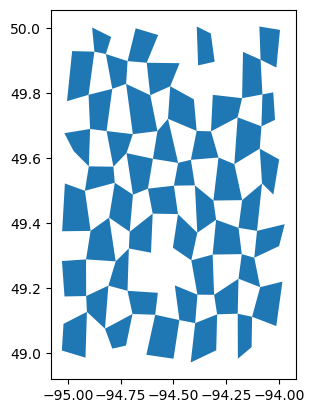

In [236]:
# Plot the solution
selected_polys_frame.plot()

In [237]:
# RESULT & DISCUSSION

# How many polygons where chosen?
selected_polys_frame.count()

parcel_id     47
carbon_sto    47
cost          47
geometry      47
dtype: int64

47 out of the 99 polygons where chosen.

In [238]:
# What is the sum of the carbon store for this set?
selected_polys_frame["carbon_sto"].sum()

2829.362899033295

The sum of the carbon store is about 2829.36 (we can also see this from our solver output above).

In [239]:
# What is the total cost vs. budget?

# Budget
cost_50_all

139644.0281603684

In [240]:
# Total cost 
selected_polys_frame["cost"].sum()

138538.0368151607

We can see that our budget is about \\$139,644.03, and the total cost of the polygons is about \\$138,538.04.

In [241]:
# Difference between cost and budget
cost_50_all - selected_polys_frame["cost"].sum()

1105.9913452077017

The difference between total cost and budget is about \\$1105.99.

In [242]:
# Are there any interesting "edge cases" or quirks?

I think something that was interesting about the solution given by the Python MLIP Pyomo is that it gave us a solution that used every other polygon (starting with parcel_id of 0) to satisfy the adjacency constraint. However, we can see that there are some gaps in our plot above, so not EVERY other polygon was used (some must've had to have been removed in an optimal way such that that we satisfy the budget constraint while maximizing carbon store).


# Short Report

### Approach and methodology
The approach that I used to solve this problem was to first research more about how Pyomo works in Python. In order to set up the problem I would need to define decision variables (what I want to control: which polygons do I select?), the objective (maximizing carbon store), and the constraints (budget and adjacency). Then it was up to translating this into code so that the Pyomo solver could solve it.

The idea was to use indicator variables that held the value of 1 if a polygon was selected and 0 otherwise. Then I could easily create the cost and adjacency contraints based off the model.

### Challenges
Using Geopandas and Pyomo is fairly new to me, so I had to do research at first to get familiar with analysis using these libraries. Once I read a little bit about it and experimented with these libraries, I got more comfortable. Online resources were helpful in figuring out how to set up the problem and debug. I had some challenges with getting the actual solver to work. I initially installed the cbc solver on my Macbook, but continued to get errors with it. This included errors with libraries not being found even though my computer would give me the path where cbc was installed with the command 'which cbc'. I tried uninstalling and reinstalling cbc and Pyomo, but that did not solve the issue. Eventually, I ended up installing the GLPK solver instead, which worked more smoothly.

### Key results and analysis
I was able to solve the constrained optimization problem using Pyomo in Python. The maximum sum of the carbon stores is 2829.36, and we are under the budget by about \\$1105 with the costs. 

As mentioned previously, I noticed that the solution gave every other polygon (with a couple gaps most likely to stay under the budget). Observe though that the solution began with polygon 0 and not polygon 1.

